# Covid-19 Forecasting - Encontrar Países Semelhantes Portugal 

Para que possamos utilizar as capacidades de deep learning e obter melhores resultados convém aumentar os dados que temos para o treino do modelo. Ao contrário das técnicas tradicionais, onde só podemos utilizar um dataset, a API do Keras permite-nos treinar uma rede com vários inputs, sendo que o número de linhas nao irá aumentar, porque ainda se tratam de séries temporais, mas a capacidade de generalizar do modelo deverá aumentar.

A ideia irá passar por arranjar países semelhantes a Portugal no que toca à série temporal dos novos casos confirmados, para que possamos alimentar uma rede LSTM com os vários países e tentar comparar os novos resultados com os modelos definidos anteriormente. 

É relevante dizer que também iremos tentar prever as mortes, juntamente com os confirmados e que o critério de semelhança podia relacionar as séries temporais das mortes, juntar as duas, ou até outro tipo de semelhança, como a quantidade de testes...etc, mas isto implicariam muito trabalho de otimização, algo que já sai do ambito deste projeto, por isso seguimos a solução mais óbiva que é retirar as semelhanças a partir dos novos casos confirmados, como vamos ver de seguida os países encontrados, muitos deles são europeus e tem condições sanitárias semelhantes a Portugal, por isso as suas mortes por milhão não deverão divergir muito das de Portugal, assumindo que países maiores tem condições de saúde proporcionais

Fica a nota de que daqui em diante iremos utilizar variáveis "xyz_por_milhão" como tentativa de normalizar um pouco os dados entre os diferentes países, porém a solução não é completamente adequada, mas é o melhor que temos de momento. 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import math

Vamos então pegar no dataset global que tinhamos analisado na Parte I

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

Vamos agora construir um dataset auxiliar para a comparação das séries temporais dos novos casos por milhão.

In [3]:
new_dataset = pd.DataFrame()
new_dataset['location'] = dataset['location']
new_dataset['new_cases_per_million'] = dataset['new_cases_per_million']

In [4]:
def calc_min(dataset, target, c_size):
    new = pd.DataFrame(columns = ['n_days', 'reported_days before min>= ' + str(c_size)])
    
    i = 0
    for index, row in dataset.iterrows(): 
        if row[target] >= c_size:
            break
        i+=1
    
    new.loc[0] = [dataset.shape[0], i]
    return new

Agora vamos analisar a quantidade de dias reportados em cada país e quantos dias passaram até atingir um mínimo de infetados, neste caso vamos assumir que esse número mínimo é 1 por milhão de habitantes, isto para tornar as séries mais interessantes e não cheias de zeros inicialmente.

In [5]:
aux2 = new_dataset.groupby('location').apply(lambda x : calc_min(x, 'new_cases_per_million', 1))
aux2 

,,n_days,reported_days before min>= 1
location,,,
Afghanistan,0,167,84
Albania,0,108,1
Algeria,0,172,78
Andorra,0,103,0
Angola,0,95,95
...,...,...,...
Western Sahara,0,60,0
World,0,177,44
Yemen,0,76,40


In [6]:
print('Média de dias registados: ', aux2['n_days'].mean())
print('Desvio Padrão de dias registados: ', aux2['n_days'].std())
print('\nMédia de dias sem casos a atingirem o limite: ', aux2['reported_days before min>= 1'].mean())
print('Desvio Padrão de dias sem casos a atingirem o limite: ', aux2['reported_days before min>= 1'].std())

Média de dias registados:  122.28301886792453
Desvio Padrão de dias registados:  37.46043845994087

Média de dias sem casos a atingirem o limite:  34.410377358490564
Desvio Padrão de dias sem casos a atingirem o limite:  34.723641315501986


Estes cálculos são relevantes para que possamos "cortar" as séries temporais em periodos relevantes para o problema e para que possam ser comparadas entre elas, ou seja, terem o mesmo número de dias registados em todos os países que forem sujeitos a esta comparação. 

Primeira iremos filtrar os países que têm o número mínimo de dias que pretendemos, retirando os dias iniciais sem registo de casos. Iremos considerar que no mínimo precisam de ter 100 dias, passando a ser este o seu número de linhas, obtivemos este número tendo em consiração os cálculos apresentados anteriormente. Tivemos também em atenção se Portugal estava contido nestes países.

Para este efeito também poderiamos ter feito interpolações nas séries temporais que não tivessem valores suficientes, mas preferimos utilizar os valores reais.

In [7]:
def is_min(dataset, target, c_size, total_size):
    j = 0
    for index, row in dataset.iterrows(): 
        if row[target] >= c_size:
            break
        j += 1
            
    if dataset.shape[0] - j - total_size >= 0:
        return True
    
    return False   

In [8]:
print(new_dataset.shape)

(25924, 2)


In [9]:
new_dataset = new_dataset.groupby('location').filter(lambda x : is_min(x, 'new_cases_per_million', 1, 100))
new_dataset = new_dataset.reset_index(drop=True)

In [10]:
print(new_dataset.shape)

(11038, 2)


In [11]:
new_dataset.groupby('location').count().head()

,new_cases_per_million
location,
Albania,108
Andorra,103
Armenia,168
Australia,177
Austria,177


De seguida temos de colocar as séries temporais com o tamanho pretendido e também mete-las de uma forma que possa ser avaliada por um modelo de machine learning não supervisionado, como o caso do K-means. Por isso, vamos passar as séries temporais de colunas para linhas, sendo que cada coluna agora vai representar um dia e as várias linhas os diferentes países.

In [12]:
# Coloca o dataset que foi passado como argumento com o tamanho pretendido
def remove_unregistered_rows(dataset, target, minimum, size):
    to_remove = []
    j = 0
    new = dataset.reset_index(drop=True)
    for index, row in new.iterrows(): 
        if row[target] >= minimum:
            break
        to_remove.append(index)
        j += 1
        
    low = size + j    
    high = dataset.shape[0]
    to_remove += range(low, high)
   
    return new.drop(to_remove)


#converte uma coluna em linha.
def turn_to_line(dataset, target):
    c = []
    for i in range(dataset.shape[0]):
        c.append('d-' + str(i))
    
    new = pd.DataFrame(columns = c)
    
    i = 0
    for v in dataset[target].values:
        i +=1
    new.loc[0] = dataset[target].values 
    
    return new

def interpolate_for_negative_values(dataset, target):
    dataset[target] = np.where((dataset[target] < 0),np.nan ,dataset[target])
    return dataset.interpolate(method='linear')
    
def transform(dataset, target, minimum, size):
    new = remove_unregistered_rows(dataset, target, minimum, size)
    new = interpolate_for_negative_values(new, target)
    return turn_to_line(new, target) 

In [13]:
chosen_countries = new_dataset.groupby('location').apply(lambda x : transform(x, 'new_cases_per_million', 1, 100))
chosen_countries.tail()

,,d-0,d-1,d-2,d-3,d-4,d-5,d-6,d-7,d-8,d-9,...,d-90,d-91,d-92,d-93,d-94,d-95,d-96,d-97,d-98,d-99
location,,,,,,,,,,,,,,,,,,,,,,
United Kingdom,0,1.223,1.974,1.723,6.378,3.697,2.239,5.995,10.017,9.531,10.400,...,25.646,14.775,18.649,22.700,20.991,22.302,14.259,18.840,16.425,17.942
United States,0,1.060,1.544,2.347,2.486,2.680,5.335,9.027,14.607,16.236,21.519,...,62.277,69.132,77.459,77.160,59.042,60.293,71.616,77.217,83.872,90.359
Uruguay,0,1.727,0.576,6.045,6.045,8.348,4.318,4.606,7.197,6.621,1.152,...,0.000,0.000,0.288,0.000,0.288,0.000,0.288,0.864,1.727,4.894
Vatican,0,1236.094,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
World,0,1.944,0.541,0.328,0.277,0.265,0.256,0.239,0.068,0.128,0.139,...,11.006,11.027,12.401,12.577,12.084,10.419,11.179,12.197,12.747,13.846


Podemos agora tentar classificar as séries temporais disponíveis no dataset chosen_countries com um método simples de K-mean clustering usando a distância euclideana. Utilizar este tipo de distância não é de todo apropriado para comparar séries temporais, porém como estas séries se tratam todas do mesmo caso, que é o covid-19, é expectável que elas tenham comportamentos semelhantes e que este método consiga um performance mínima.

Vamos então analisar os resultados.

In [14]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10)
model.fit(chosen_countries)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [15]:
predictions = model.predict(chosen_countries)
predictions

array([0, 7, 6, 0, 0, 6, 8, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 8, 0, 0,
       8, 0, 0, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0, 0, 6, 0, 0, 0, 0, 9, 0, 0,
       5, 0, 5, 0, 8, 0, 6, 0, 5, 0, 8, 2, 0, 0, 3, 0, 0, 6, 0, 0, 0, 8,
       5, 8, 0, 5, 8, 5, 0, 1, 0], dtype=int32)

Sabemos que portugal se encontra no índice 50. Vejamos então a que grupo foi atribuido. Infelizmente não temos classes naturais para realizar a comparação dos grupos obtidos pelo clustering, porém o mais importante será termos uma forma semi-automática de encontrar séries parecidas com a de Portugal.

In [16]:
print("Índice de portugal: ", chosen_countries.index.get_loc('Portugal'))

Índice de portugal:  slice(54, 55, None)


In [17]:
grupo = predictions[50]
print("Grupo de Portugal: ", grupo)

Grupo de Portugal:  6


Vejamos então todos os países deste grupo:

In [18]:
def get_group(group):
    res = []
    n = 0
    for i in predictions:
        if (i == group):
            index = chosen_countries.index[n]
            res.append(index[0])
            print(index)
        n += 1
    return res

In [19]:
portugal_group = get_group(grupo)

('Armenia', 0)
('Bahrain', 0)
('Kuwait', 0)
('Oman', 0)
('Singapore', 0)


In [20]:
def plot_group(rows, columns, group):
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,20))
    x = y = 0
    for i in group:
        if y == columns:
            break
        chosen_countries.loc[i].transpose().plot(kind='bar', ax=axes[x][y], subplots=True, legend=False)
        axes[x][y].set_title(i)
        x += 1
        if x == rows:
            x = 0
            y += 1

    for axis in axes.flat:
        plt.setp(axis.get_xticklabels(), visible=False) 
    plt.show()

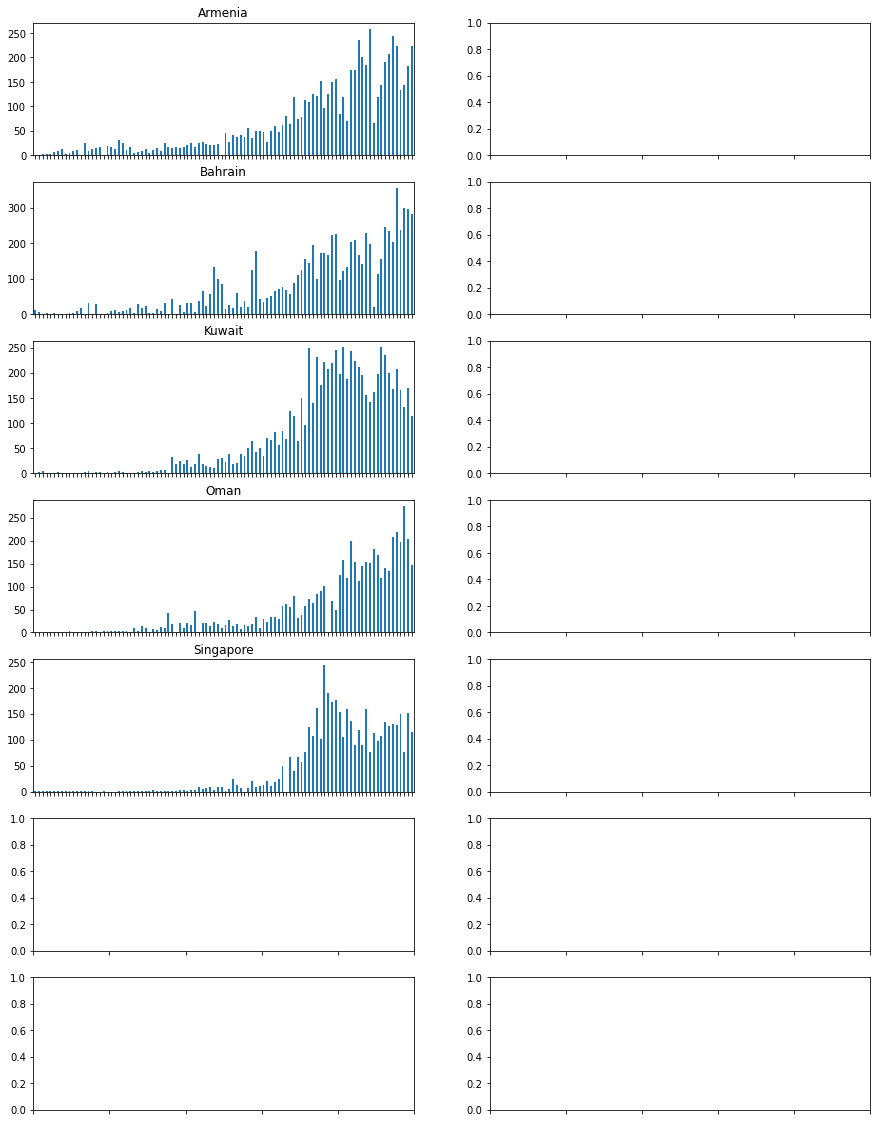

In [21]:
rows = 7
columns = 2
plot_group(rows, columns, portugal_group)

Apesar de haver algumas diferenças e um caso não tão semelhante como é o caso da Holanda (Netherlands) os resultados parecem satisfatórios, tendo em conta a distribuição das séries temporais ao longo do tempo. Casos como Liechtenstein e Mónaco não se parecem encaixar no grupo, apesar de tudo.

Vejamos agora outro grupo para termos de comparação.

In [22]:
another_group = get_group(7)

('Andorra', 0)


In [23]:
len(another_group)

1

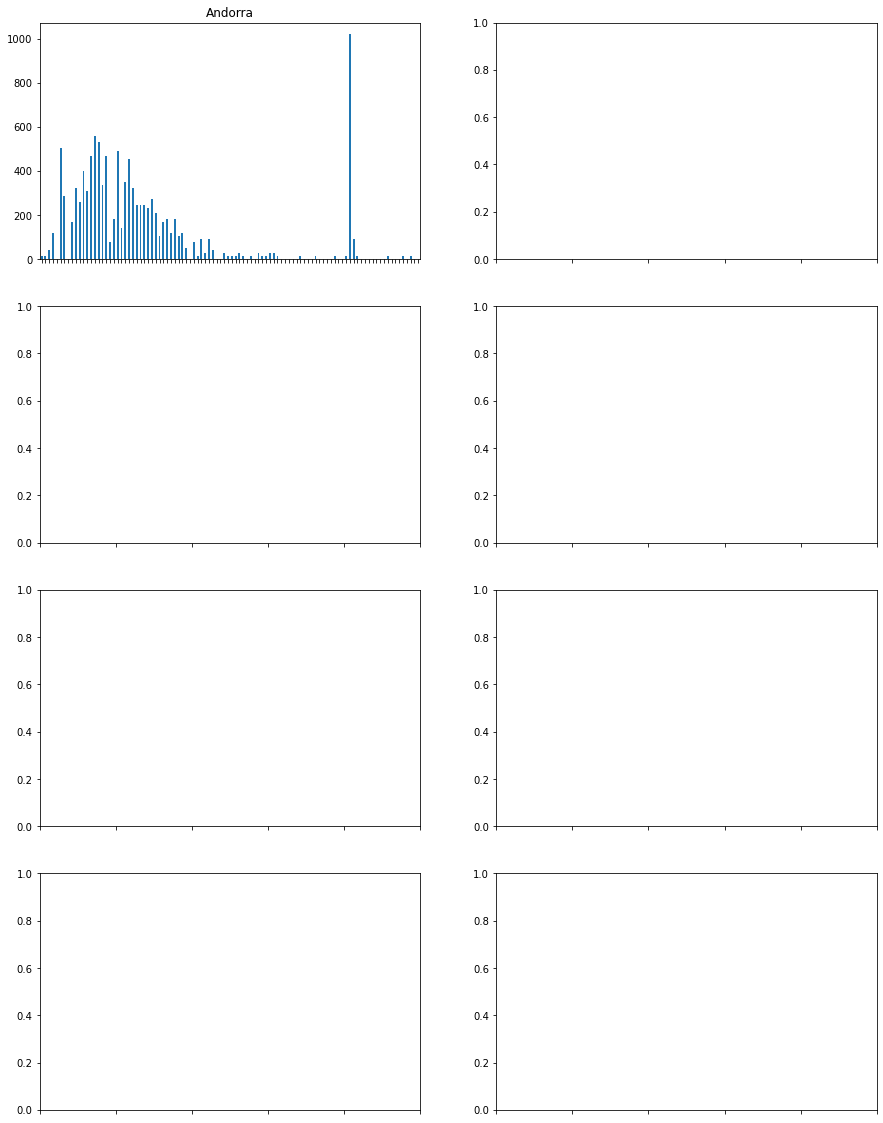

In [24]:
plot_group(4, 2, another_group)

Podemos ver no grupo 6 alguns países que não tem nada a ver com Portugal, no que toca à série temporal, como a Singapura e as Maldivas.

Com a análise destes resultados e pelas nossas experiências constatamos que o número de clusters era muito relevante para o grupo formado, mesmo que esse número fosse elevado, ou seja, entre 9 e 10 clusters havia uma grande diferença. Como achamos que estamos a perder casos parecidos com o português vamos experimentar utilizar DTW (Dynamic Time Warping), em que esta métrica tenta encontrar o alinhamento ótimo não linear entre duas séries temporais. 

Para este efeito vamos usar o método mais lento (quadrático), porque os dados são relativamente pequenos, para trabalho futuro poderiamos otimizar.

Fonte DTW: http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html

In [25]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

Infelizmente pelo que sabemos não existe nenhum módulo de aprendizagem não supervisionada que utilize esta técnica, portanto iremos apenas tentar identificar países semelhantes a Portugal através desta métrica e sem cálcular os grupos em sí.

De seguida fazemos esse cálculo e em paralelo verificamos os países que pertencem ao grupo de portugal antigo, obtido através do k-means, isto para termos a noção do valor da métrica associado a países que sabemos que são semelhantes.

In [26]:
new_portugal_group = []
for i in chosen_countries.index:
    distance = DTWDistance(chosen_countries.loc['Portugal'].iloc[0], chosen_countries.loc[i[0]].iloc[0])
    if i[0] in portugal_group:
        print("In Portugal group!! ", i, distance)
    else: 
        print(i[0], distance)
    if distance <= 200:
        new_portugal_group.append(i[0])

Albania 259.5439774180861
Andorra 1462.2523092524077
In Portugal group!!  ('Armenia', 0) 589.8841230589276
Australia 315.9189325159226
Austria 156.50201544708617
In Portugal group!!  ('Bahrain', 0) 736.6075978260067
Belgium 216.78744906705285
Bhutan 352.88720007673845
Bosnia and Herzegovina 253.3769894682624
Brunei 286.06594350603865
Bulgaria 264.721342061799
Canada 161.13877034407327
Chile 2275.3634460314247
China 395.1321667189347
Costa Rica 306.4324897722173
Croatia 313.87387580682787
Cyprus 185.34404819416238
Czech Republic 237.71902955800581
Denmark 156.90612871076763
Ecuador 559.7150090831942
Estonia 171.2843623915359
Finland 202.20723359711937
France 126.63822236295799
Georgia 381.4456199433937
Germany 160.89514431765798
Greece 351.49977228157627
Guyana 339.7514948399787
Hungary 319.40729782051
Iceland 393.01558827481637
Iran 150.5294294614844
Ireland 236.39163598993935
Israel 103.32655970876995
Italy 146.14403723381943
Jamaica 349.7252334547795
Jordan 422.96477646962506
Kosovo 

Pegando na Noruega, Holanda e Reino Unido, que consideramos que tem séries muito parecidas com a de Portugal vemos que tem um valor para a métrica de 171, 144 e 123, respetivamente, sendo que, por exemplo, a China tem um valor de 395. Decidimos então que o limite superior da métrica poderá ser 200. Obviamente que isto está longe de ser preciso e otimizado, porém para o contexto deste trabalho parece-nos adequado.

Podemos ver que países como o Liechtenstein (464) e Mónaco (267) já não vão fazer parte do grupo e países.

Vejamos então o novo grupo.

In [27]:
print(new_portugal_group)

['Austria', 'Canada', 'Cyprus', 'Denmark', 'Estonia', 'France', 'Germany', 'Iran', 'Israel', 'Italy', 'Malta', 'Netherlands', 'Norway', 'Portugal', 'Serbia', 'Spain', 'United Arab Emirates', 'United Kingdom']


O grupo cresceu, mas não muito em relação ao antigo, porém houve ganhos, por exemplo Chipre já foi incluido, tendo uma série semelhante (intuitivamente), como podemos ver no seguinte gráfico, mas também introduziu os Emirados Árabes Unidos, cuja série não é tão semelhante, mas isto é apenas uma análise empírica.

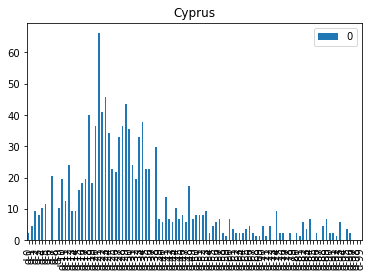

In [28]:
chosen_countries.loc['Cyprus'].transpose().plot(kind='bar', title='Cyprus')

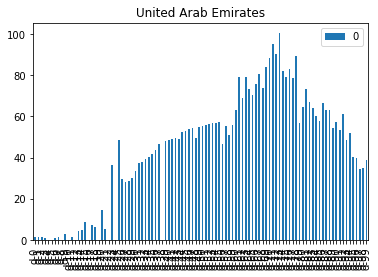

In [29]:
chosen_countries.loc['United Arab Emirates'].transpose().plot(kind='bar', title='United Arab Emirates')

Posto isto vamos guardar os países que fazem parte deste novo grupo para que possam de seguida alimentar uma rede LSTM. Vamos recolher apenas as variáveis que queremos prever, sendo elas os new_cases_per_million e new_deaths_per_million. Poderiamos pegar em mais algumas como features, mas nenhuma delas apresenta grande correlação com as variáveis a prever e existem países dentro do grupo que não têm esses registos como é o caso de Chipre, Malta e Emirados Árabes Unidos no que toca a número de novos testes, por exemplo.

In [30]:
def transform_simple(dataset, target, minimum, size):
    dataset = remove_unregistered_rows(dataset, target, minimum, size)
    new = np.where((dataset[target] < 0),np.nan ,dataset[target])
    dataset[target] = new
    return dataset.interpolate(method='linear')

In [31]:
new_dataset = pd.DataFrame()
new_dataset['location'] = dataset['location']
new_dataset['new_cases_per_million'] = dataset['new_cases_per_million']
new_dataset['new_deaths_per_million'] = dataset['new_deaths_per_million']


new_dataset = new_dataset.groupby('location').filter(lambda x : x['location'].iloc[0] in new_portugal_group).reset_index(drop=True)
dataset_to_save = new_dataset.groupby('location').apply(lambda x : transform_simple(x, 'new_cases_per_million', 1, 100)).reset_index(drop=True)

In [32]:
dataset_to_save

,location,new_cases_per_million,new_deaths_per_million
0,Austria,1.332,0.000
1,Austria,3.664,0.000
2,Austria,2.776,0.000
3,Austria,0.333,0.000
4,Austria,3.220,0.000
...,...,...,...
1795,United Kingdom,22.302,0.530
1796,United Kingdom,14.259,0.560
1797,United Kingdom,18.840,3.432
1798,United Kingdom,16.425,2.710


In [33]:
dataset_to_save.to_csv("portugal_group_dataset.csv", index = "False")